In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
import copy

# data processing

In [1]:
def read_mydata(dataname):
  # read site data
  df = pd.read_csv(dataname,delimiter = '\t') # Note: same directory for the ipynb file and site data here!!!!!
  df.dtypes # change object to float

  df = df.replace(' ',np.NaN) # deal with nan
  df['Biome'] = df['Biome'].astype(float)
  df['Fpar'] = df['Fpar'].astype(float)
  df['LAI'] = df['LAI'].astype(float)

  df.Fpar = df.Fpar/100 # Fpar: [0,1]
  df.LAI = df.LAI/10 # LAI: [0,7]
  df.SWRad = df.SWRad*24*60*60/1000000 # The unit of SWRAD is J/(m2*second), here we convert it to MJ/(m2*day)

  month_day = [31,28,31,30,31,30,31,31,30,31,30,31]

  Fpar = pd.Series([0]*365).astype(float)
  LAI = pd.Series([0]*365).astype(float)
  doy_start = 0
  for imonth in np.arange(1,13):
      doy_index = np.arange(doy_start,sum(month_day[0:imonth]))
      n_day_this_month = month_day[imonth-1]

      this_Fpar = df.Fpar[imonth-1]
      this_Fpar_all_month = [this_Fpar]*n_day_this_month
      Fpar[doy_index] = this_Fpar_all_month

      this_LAI = df.LAI[imonth-1]
      this_LAI_all_month = [this_LAI]*n_day_this_month
      LAI[doy_index] = this_LAI_all_month

      doy_start = doy_index[-1]+1

  df.Fpar = Fpar
  df.LAI = LAI
  df

  # read look up table
  LUT = pd.read_csv('LUT.dat',delimiter = '\t')
  LUT.index = LUT.Parameter
  LUT = LUT.iloc[:,1:12]
  LUT

  d = dict()
  d['df'] = df
  d['LUT'] = LUT

  return d


# main function

In [3]:
def get_Epsilon(LUT,Tmin,VPD,Biome_type):
    Epsilon_max = LUT.iloc[0,int(Biome_type-1)]
    Tmin_max = LUT.iloc[1,int(Biome_type-1)]
    Tmin_min = LUT.iloc[2,int(Biome_type-1)]
    VPD_max = LUT.iloc[3,int(Biome_type-1)]
    VPD_min = LUT.iloc[4,int(Biome_type-1)]

    # for temperature
    TMIN_scalar = pd.Series([np.nan]*365).astype(float)
    range = Tmin_max - Tmin_min  
    mask = Tmin < Tmin_min
    TMIN_scalar.loc[mask] = 0
    mask = Tmin > Tmin_max
    TMIN_scalar.loc[mask] = 1
    mask = (Tmin <= Tmin_max) & (Tmin >= Tmin_min)
    TMIN_scalar.loc[mask] = (Tmin.loc[mask]-Tmin_min)/range

    # for VPD
    VPD_scalar = pd.Series([np.nan]*365).astype(float)
    range = VPD_max - VPD_min
    mask = VPD < VPD_min
    VPD_scalar.loc[mask] = 1
    mask = VPD > VPD_max
    VPD_scalar.loc[mask] = 0
    mask = (VPD <= VPD_max) & (VPD >= VPD_min)
    VPD_scalar.loc[mask] = (VPD_max - VPD.loc[mask])/range

    Epsilon = Epsilon_max * TMIN_scalar * VPD_scalar # kg C/MJ

    return Epsilon

In [4]:
def get_Daily_GPP(SWRad,Fpar,Epsilon):
    IPAR = 0.45 * SWRad # PAR incident on the vegetation (IPAR): MJ/(m2*day); Incident shortwave solar radiation(SWRad)
    APAR = IPAR * Fpar # PAR absorbed by vegetation(APAR) = IPAR * Fraction of IPAR absorbed by vegetation (FPAR)
    Daily_GPP = Epsilon * APAR # kg C/(m2*day)
    return Daily_GPP

In [5]:
def get_Leaf_MR(LUT,LAI,Tavg,Biome_type):
    SLA = LUT.iloc[5,int(Biome_type-1)]
    leaf_mr_base = LUT.iloc[9,int(Biome_type-1)]
    Q10_mr = LUT.iloc[6,int(Biome_type-1)]

    leaf_mass = LAI*0.1/SLA
    leaf_mr = leaf_mass * leaf_mr_base * np.power(Q10_mr, (Tavg-20)/10)
    return leaf_mr


In [6]:
def get_Froot_MR(LUT,LAI,Tavg,Biome_type):
    SLA = LUT.iloc[5,int(Biome_type-1)]
    froot_mr_base = LUT.iloc[10,int(Biome_type-1)]
    Q10_mr = LUT.iloc[6,int(Biome_type-1)]
    froot_leaf_ratio = LUT.iloc[7,int(Biome_type-1)]

    leaf_mass = LAI/SLA
    fine_root_mass = leaf_mass * froot_leaf_ratio
    fine_root_mr = fine_root_mass * froot_mr_base * np.power(Q10_mr, (Tavg-20)/10)
    return fine_root_mr

In [7]:
def get_Livewood_MR(LUT,LAI,Tavg,Biome_type):
    SLA = LUT.iloc[5,int(Biome_type-1)]
    livewood_mr_base = LUT.iloc[11,int(Biome_type-1)]
    Q10_mr = LUT.iloc[6,int(Biome_type-1)]
    livewood_ratio = LUT.iloc[8,int(Biome_type-1)]

    annual_leaf_mass_max = max(LAI/SLA)
    livewood_mass = annual_leaf_mass_max * livewood_ratio
    annsum_mr_index = np.nansum(np.power(Q10_mr, (Tavg-20)/10))

    livewood_mr = livewood_mass * livewood_mr_base * annsum_mr_index
    return livewood_mr

In [8]:
def get_leaf_GR(LUT,LAI,Biome_type):
    SLA = LUT.iloc[5,int(Biome_type-1)]
    ann_turnover_proportion = LUT.iloc[16,int(Biome_type-1)]
    Q10_mr = LUT.iloc[6,int(Biome_type-1)]
    leaf_gr_base = LUT.iloc[12,int(Biome_type-1)]

    annual_leaf_mass_max = max(LAI/SLA)
    leaf_gr = annual_leaf_mass_max * ann_turnover_proportion * leaf_gr_base

    return leaf_gr

In [9]:
def get_Annual_GR(LUT,Leaf_GR,Biome_type):
    froot_leaf_gr_ratio = LUT.iloc[13,int(Biome_type-1)]
    livewood_leaf_gr_ratio = LUT.iloc[14,int(Biome_type-1)]
    deadwood_leaf_gr_ratio = LUT.iloc[15,int(Biome_type-1)]


    Froot_GR = Leaf_GR * froot_leaf_gr_ratio
    Livewood_GR = Leaf_GR * livewood_leaf_gr_ratio
    Deadwood_GR = Leaf_GR * deadwood_leaf_gr_ratio
    Annual_GR = Leaf_GR + Froot_GR + Livewood_GR + Deadwood_GR

    return Annual_GR

In [10]:
def PEM(df,LUT):

    # Get the biome type
    Biome_type = df.Biome[0]

    # Daily GPP
    Epsilon = get_Epsilon(LUT,df.Tmin,df.VPD,Biome_type)
    Daily_GPP = get_Daily_GPP(df.SWRad,df.Fpar,Epsilon)

    # Maintenance Respiration
    Leaf_MR = get_Leaf_MR(LUT,df.LAI,df.Tavg,Biome_type) # daily
    Froot_MR = get_Froot_MR(LUT,df.LAI,df.Tavg,Biome_type) # daily
    Livewood_MR = get_Livewood_MR(LUT,df.LAI,df.Tavg,Biome_type) # annual

    Daily_MR = Leaf_MR + Froot_MR + Livewood_MR/365;
    Annual_MR = Leaf_MR.sum() + Froot_MR.sum() + Livewood_MR.sum()

    # Growth Respiration
    Leaf_GR = get_leaf_GR(LUT,df.LAI,Biome_type) # annual
    Annual_GR = get_Annual_GR(LUT,Leaf_GR,Biome_type); # annual, including leaf

    # Get daily NPP, autotrophic respiration, and annual GPP, NPP and autotrophic respiration
    Annual_GPP = Daily_GPP.sum()
    Daily_NPP = Daily_GPP - Daily_MR - Annual_GR/365
    Annual_NPP = Annual_GPP - Annual_MR - Annual_GR
    Daily_AR = Daily_MR + Annual_GR/365
    Annual_AR = Annual_MR + Annual_GR

    # calculate monthly GPP, NPP and autotrophic respiration
    doy_start = 0
    month_day = [31,28,31,30,31,30,31,31,30,31,30,31]
    Monthly_GPP = pd.Series([0]*12).astype(float)
    Monthly_NPP = pd.Series([0]*12).astype(float)
    Monthly_AR = pd.Series([0]*12).astype(float)
    for imonth in np.arange(1,13):
        doy_index = np.arange(doy_start,sum(month_day[0:imonth]))
        Monthly_GPP[imonth-1] = np.nansum(Daily_GPP[doy_index])
        Monthly_NPP[imonth-1] = np.nansum(Daily_NPP[doy_index])
        Monthly_AR[imonth-1] = np.nansum(Daily_AR[doy_index])

        doy_start = doy_index[-1]+1

    d = dict()
    d['Daily_GPP'] = Daily_GPP
    d['Monthly_GPP'] = Monthly_GPP
    d['Annual_GPP'] = Annual_GPP
    d['Daily_NPP'] = Daily_NPP
    d['Monthly_NPP'] = Monthly_NPP
    d['Annual_NPP'] = Annual_NPP
    d['Daily_AR'] = Daily_AR
    d['Monthly_AR'] = Monthly_AR
    d['Annual_AR'] = Annual_AR
    d['Annual_GR'] = Annual_GR
    d['Annual_MR'] = Annual_MR

    return d


In [11]:
# calculate GPP and NPP
data1 = read_mydata('r40c220-11.dat')
df1 = data1['df']
LUT1 = data1['LUT']
result1 = PEM(df1,LUT1)

data2 = read_mydata('r94c116-2.dat')
df2 = data2['df']
LUT2 = data2['LUT']
result2 = PEM(df2,LUT2)

data3 = read_mydata('r115c310-9.dat')
df3 = data3['df']
LUT3 = data3['LUT']
result3 = PEM(df3,LUT3)

# Visualization

## daily plot

In [18]:
def draw_daily_plot(mydata,plot_name):
  iday = np.arange(1,366)
  df_year = {'Daily_AR':mydata['Daily_AR'],'Daily_NPP':mydata['Daily_NPP']}
  df_year = pd.DataFrame(df_year)
  df_year = df_year.set_index(np.arange(1,366))

  plt.figure()
  plt.rcParams.update({'font.size': 16}) # must set in top
  ax = df_year.plot(kind = 'bar', stacked=True,xlabel = 'Day of year',ylabel = 'carbon flux density(kg C/m$^2$/day)',
                    title = plot_name,figsize =(15, 4), fontsize=14, rot = 0, width = 1, alpha=0.6)
  ax.plot(iday-1, mydata['Daily_GPP'], label = "Daily_GPP",color = 'green')
  ax.legend(fontsize=14)
  plt.xticks([49,99, 149, 199, 249, 299, 349])
  plt.show()

<Figure size 640x480 with 0 Axes>

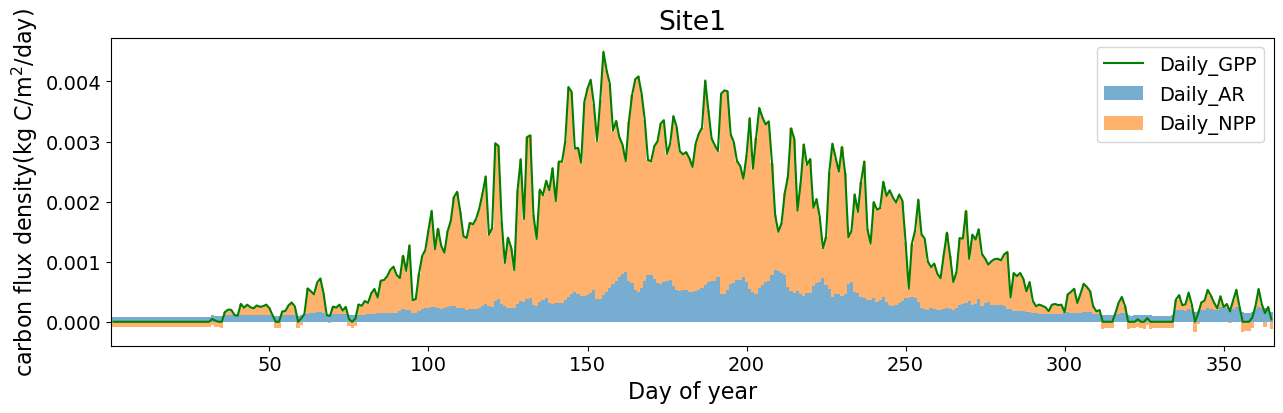

In [14]:
draw_daily_plot(result1,'Site1')

<Figure size 640x480 with 0 Axes>

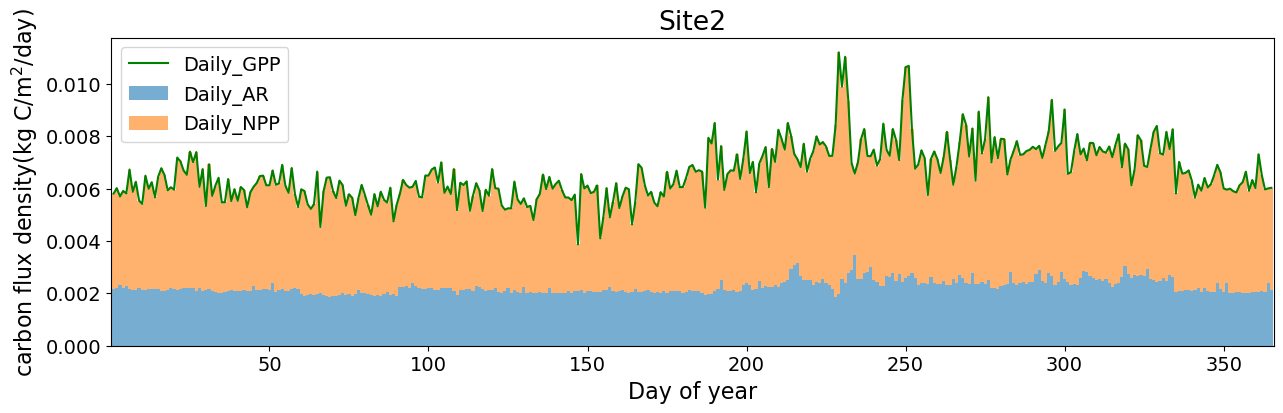

In [15]:
draw_daily_plot(result2,'Site2')

<Figure size 640x480 with 0 Axes>

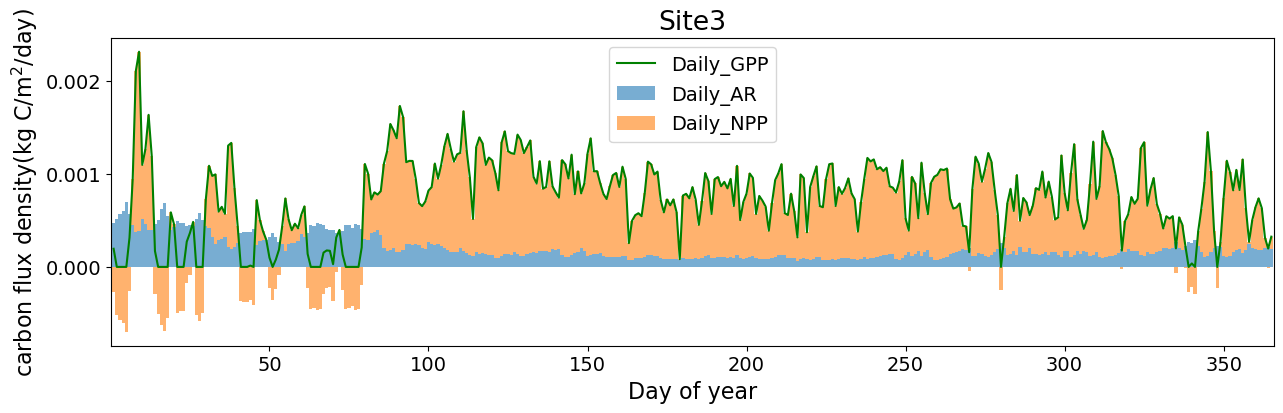

In [16]:
draw_daily_plot(result3,'Site3')

## Monthly plot

In [17]:
def draw_monthly_plot(mydata,plot_name):
  imonth = np.arange(1,13)
  df_month = {'Monthly_AR':mydata['Monthly_AR'],'Monthly_NPP':mydata['Monthly_NPP']}
  df_month = pd.DataFrame(df_month)
  df_month = df_month.set_index(np.arange(1,13))

  plt.figure()
  plt.rcParams.update({'font.size': 16}) # must set in top
  ax = df_month.plot(kind = 'bar', stacked=True,xlabel = 'month',ylabel = 'carbon flux density(kg C/m$^2$/month)',title = plot_name,figsize =(8, 6), fontsize=14,rot = 0)
  ax.plot(imonth-1, mydata['Monthly_GPP'], label = "Monthly_GPP",color = 'green')
  ax.legend(fontsize=14)

  plt.show()

<Figure size 640x480 with 0 Axes>

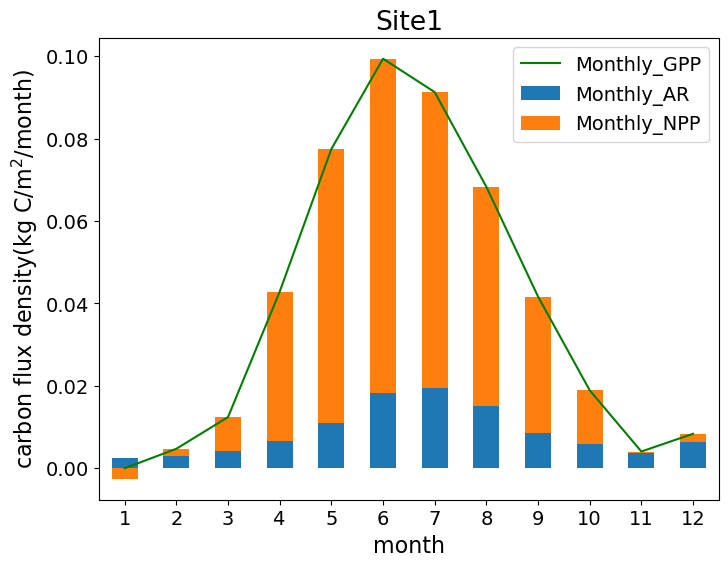

In [18]:
draw_monthly_plot(result1,'Site1')

<Figure size 640x480 with 0 Axes>

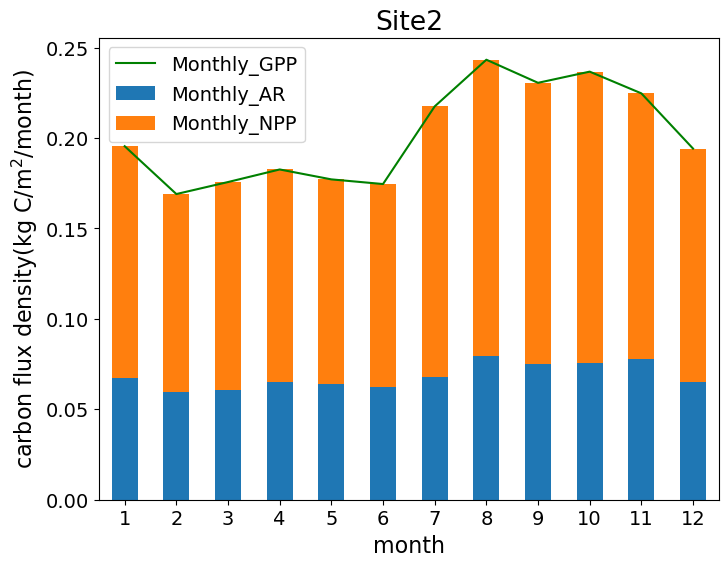

In [19]:
draw_monthly_plot(result2,'Site2')

<Figure size 640x480 with 0 Axes>

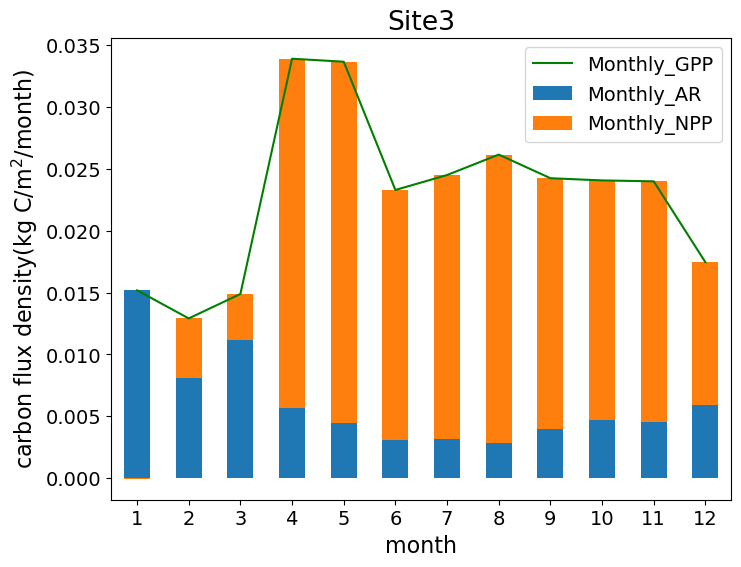

In [20]:
draw_monthly_plot(result3,'Site3')

## Additional plot

In [21]:
def draw_GPP_NPP(mydata):
  GPP = mydata['Daily_GPP']
  NPP = mydata['Daily_NPP']

  xy = np.vstack([GPP,NPP])
  z = gaussian_kde(xy)(xy)

  fig, ax = plt.subplots()
  myplot = ax.scatter(GPP, NPP, c=z, s=20, cmap='Spectral')
  fig.colorbar(myplot, label='Number of points per pixel')
  ax.set_xlabel('GPP(kg C/m$^2$/day)',fontsize=14)
  ax.set_ylabel('NPP(kg C/m$^2$/day)',fontsize=14)
  ax.set_title('GPP v.s. NPP',fontsize=20)
  r = pearsonr(GPP, NPP)
  xrange = ax.get_xlim()[1] - ax.get_xlim()[0]
  xpos = ax.get_xlim()[0] + xrange *0.08
  yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
  ypos = ax.get_ylim()[1] - yrange *0.1
  plt.text(xpos, ypos, "r =  {:.2f}".format(r.statistic), fontsize=12)
  plt.show()



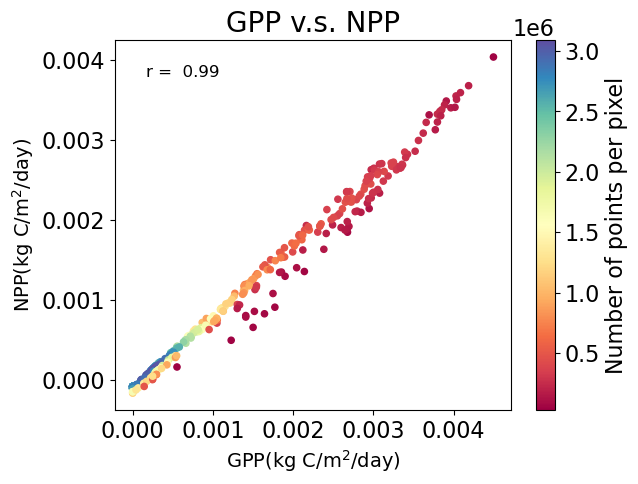

In [22]:
draw_GPP_NPP(result1)

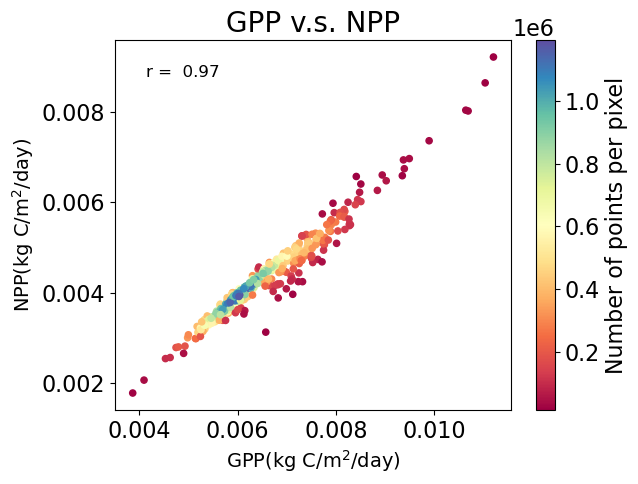

In [23]:
draw_GPP_NPP(result2)

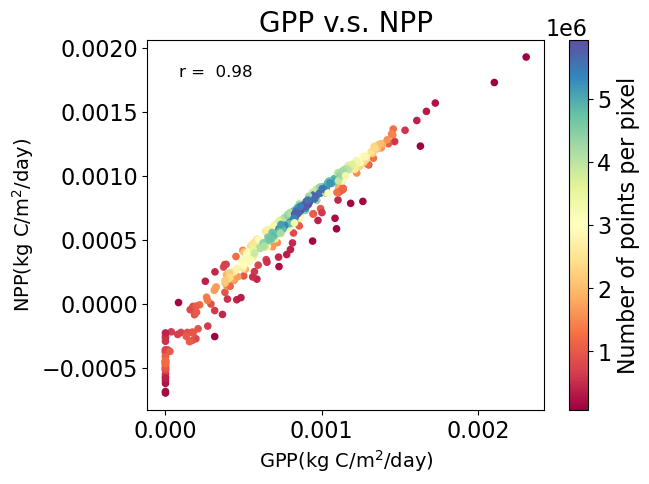

In [24]:
draw_GPP_NPP(result3)

In [25]:
def draw_CUE(mydata,plot_name):
  iday = np.arange(1,366)
  GPP = mydata['Daily_GPP']
  NPP = mydata['Daily_NPP']
  CUE = (NPP/GPP[NPP/GPP > 0]).fillna(0)
  xy = np.vstack([iday-1,CUE])
  z = gaussian_kde(xy)(xy)
  fig, ax = plt.subplots()
  myplot = ax.scatter(iday-1, CUE, c=z, cmap='Spectral')
  fig.colorbar(myplot, label='density')
  ax.set_xlabel('Day of year',fontsize=14)
  ax.set_ylabel('Carbon use efficiency)',fontsize=14)
  ax.set_title(plot_name,fontsize=20)

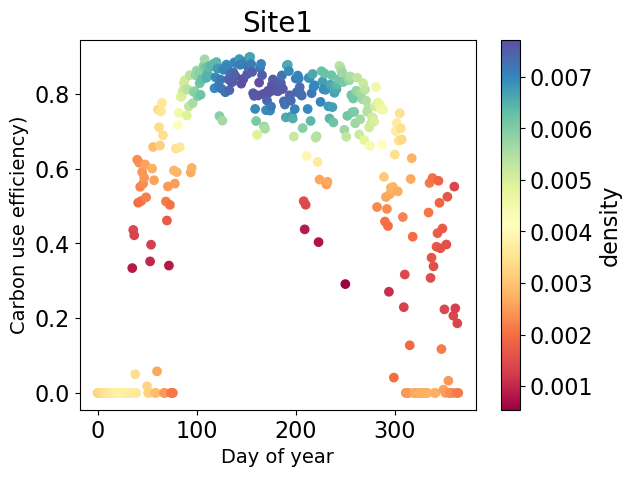

In [26]:
draw_CUE(result1,'Site1')

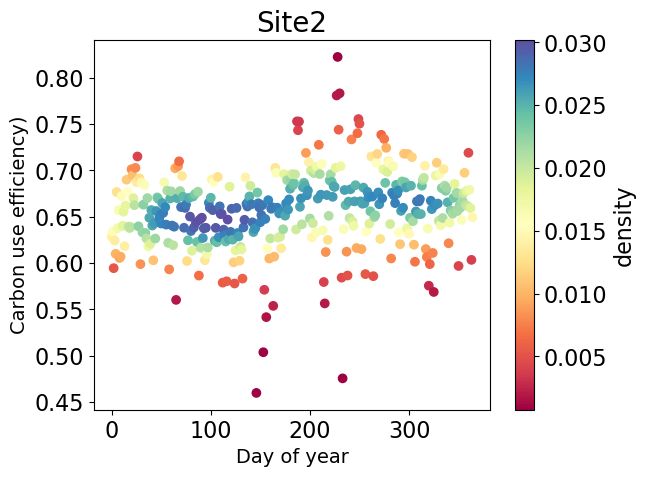

In [27]:
draw_CUE(result2,'Site2')

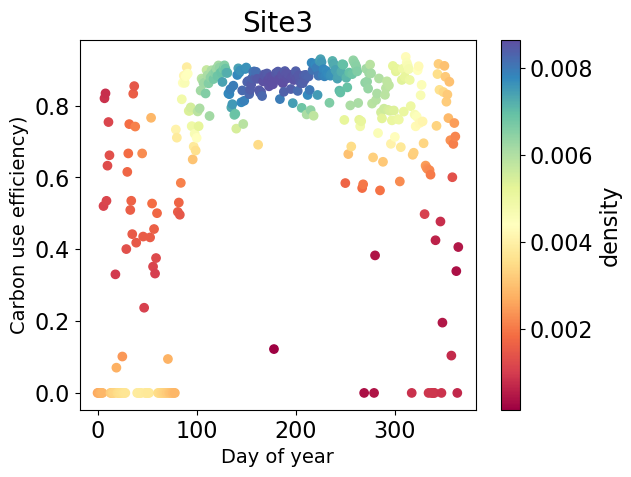

In [28]:
draw_CUE(result3,'Site3')

# Correlation analysis

In [29]:
def GPP_NPP_Corr(data, result):
  GPP = result['Daily_GPP']
  NPP = result['Daily_NPP']
  df = data.iloc[:,1:7]

  d = {'factor': ['SWRad', 'Tavg', 'Tmin', 'VPD', 'Fpar', 'LAI'], 'GPP Cor': [0, 0, 0, 0, 0, 0],'NPP Cor': [0, 0, 0, 0, 0, 0]}
  CorResult = pd.DataFrame(data=d)
  CorResult['GPP Cor'] = CorResult['GPP Cor'].astype(float)
  CorResult['NPP Cor'] = CorResult['NPP Cor'].astype(float)

  for i in np.arange(0,6):
    r = pearsonr(GPP, df.iloc[:,i])
    CorResult.iloc[i,1] = round(r.statistic, 2)
    r = pearsonr(NPP, df.iloc[:,i])
    CorResult.iloc[i,2] = round(r.statistic, 2)

  return CorResult


In [30]:
GPP_NPP_Corr(df1,result1)

,factor,GPP Cor,NPP Cor
0,SWRad,0.89,0.89
1,Tavg,0.82,0.78
2,Tmin,0.79,0.75
3,VPD,0.58,0.52
4,Fpar,0.50,0.48
5,LAI,0.69,0.67


In [31]:
GPP_NPP_Corr(df2,result2)

,factor,GPP Cor,NPP Cor
0,SWRad,0.94,0.95
1,Tavg,0.28,0.10
2,Tmin,-0.46,-0.53
3,VPD,0.50,0.37
4,Fpar,0.66,0.55
5,LAI,0.66,0.54


In [32]:
GPP_NPP_Corr(df3,result3)

,factor,GPP Cor,NPP Cor
0,SWRad,-0.14,-0.21
1,Tavg,-0.51,-0.65
2,Tmin,-0.48,-0.61
3,VPD,-0.70,-0.80
4,Fpar,0.08,-0.01
5,LAI,-0.10,-0.27


# Sensitivity analysis

In [33]:
def sensitivityAna(var_name,mydata):
  mypercent = np.arange(50,151)
  d = {'percent': mypercent, 'Annual GPP': [0]*101,'Annual NPP': [0]*101}
  sen_result = pd.DataFrame(data=d).astype(float)
  for percent in mypercent:
    sen_df = copy.deepcopy(mydata)
    sen_df[var_name] = sen_df[var_name]*percent * 0.01
    result = PEM(sen_df,LUT1)
    sen_result.iloc[percent-50,1] = result['Annual_GPP']
    sen_result.iloc[percent-50,2] = result['Annual_NPP']

  fig, ax = plt.subplots(figsize=(6, 6))
  # plot lines
  ax.plot(sen_result['percent'], sen_result['Annual GPP'], label = "Annual GPP")
  ax.plot(sen_result['percent'], sen_result['Annual NPP'], label = "Annual NPP")
  ax.plot(sen_result['percent'], [sen_result['Annual GPP'].iloc[50]]*101, linestyle='dashed',color='grey', label = "real GPP")
  ax.plot(sen_result['percent'], [sen_result['Annual NPP'].iloc[50]]*101, linestyle='dotted',color='grey', label = "real NPP")
  ax.set_xlabel('Percent(%)',fontsize=14)
  ax.set_ylabel('carbon flux density(kg C/m$^2$/year)',fontsize=14)
  ax.set_title(var_name + ' sensitivity analysis',fontsize=20)
  #ax.legend()
  plt.show()

  return sen_result




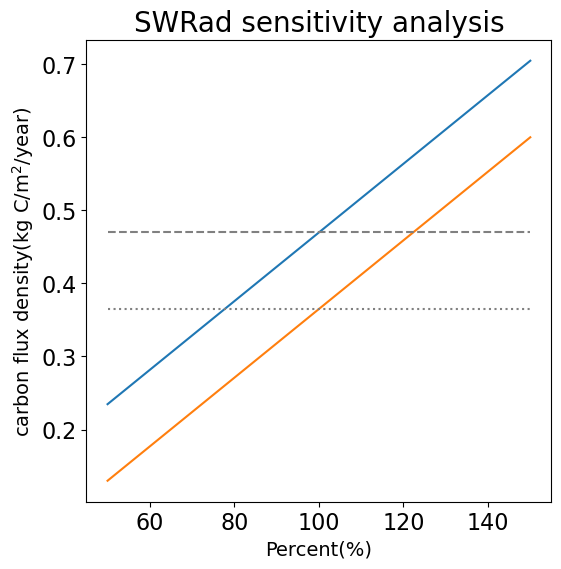

In [34]:
sen_result = sensitivityAna('SWRad',df1)

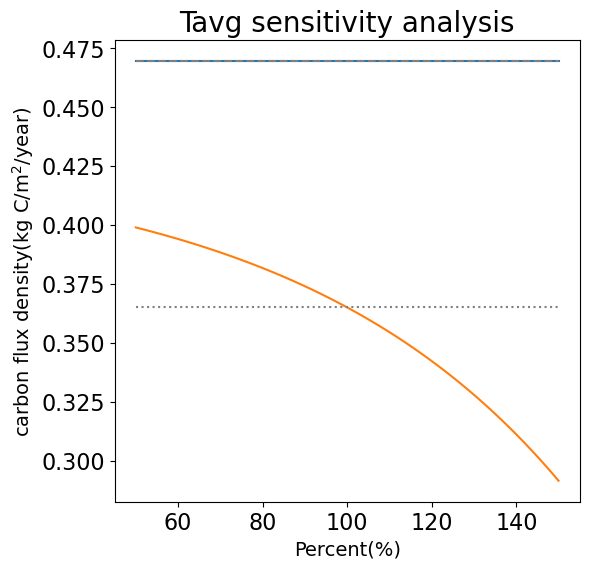

In [35]:
sen_result = sensitivityAna('Tavg',df1)

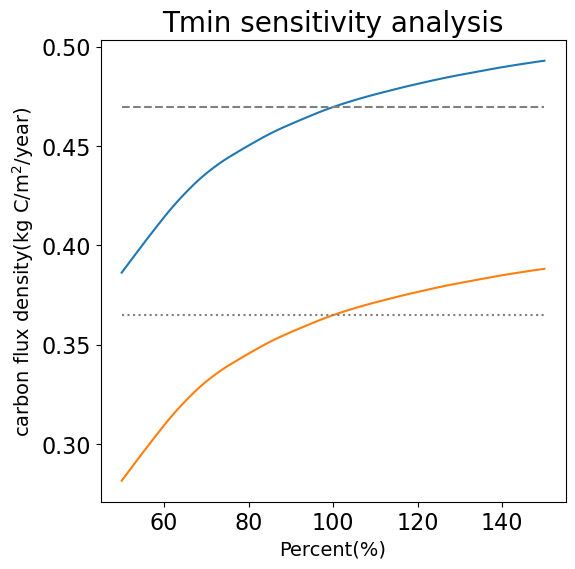

In [36]:
sen_result = sensitivityAna('Tmin',df1)

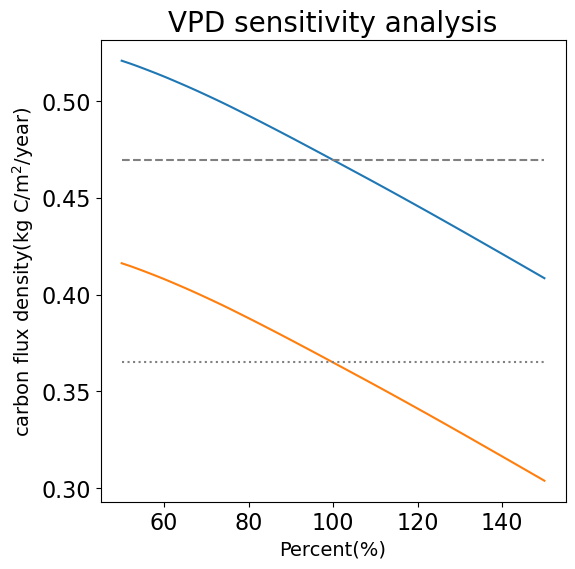

In [37]:
sen_result = sensitivityAna('VPD',df1)

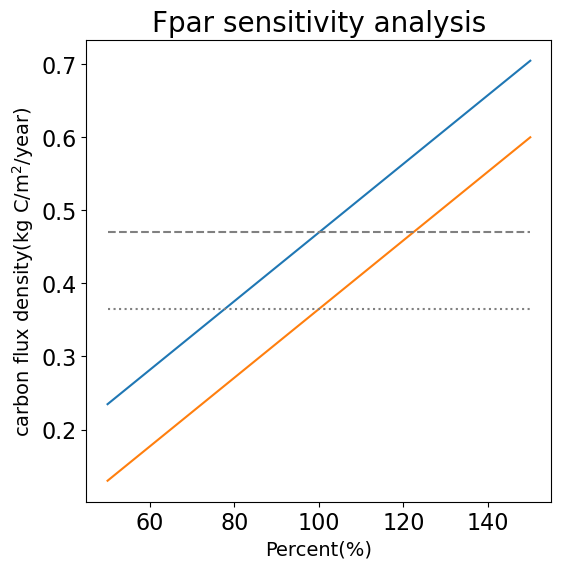

In [38]:
sen_result = sensitivityAna('Fpar',df1)

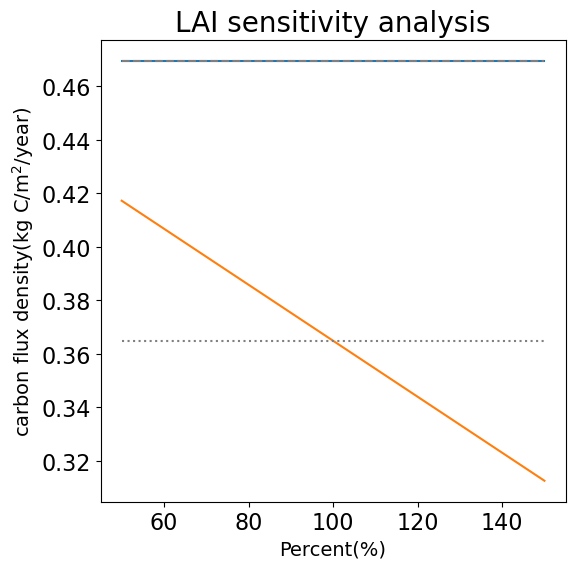

In [39]:
sen_result = sensitivityAna('LAI',df1)

In [40]:
data1 = read_mydata('r40c220-11.dat')
df1 = data1['df']
LUT1 = data1['LUT']
result1 = PEM(df1,LUT1)

data2 = read_mydata('r94c116-2.dat')
df2 = data2['df']
LUT2 = data2['LUT']
result2 = PEM(df2,LUT2)

data3 = read_mydata('r115c310-9.dat')
df3 = data3['df']
LUT3 = data3['LUT']
result3 = PEM(df3,LUT3)

# MODIS Version C6.1

In [12]:
def get_Leaf_MR_new(LUT,LAI,Tavg,Biome_type):
    SLA = LUT.iloc[5,int(Biome_type-1)]
    leaf_mr_base = LUT.iloc[9,int(Biome_type-1)]
    Q10_mr = 3.22 - 0.046*Tavg

    leaf_mass = LAI*0.1/SLA
    leaf_mr = leaf_mass * leaf_mr_base * np.power(Q10_mr, (Tavg-20)/10)
    return leaf_mr


In [13]:
def get_Froot_MR_new(LUT,LAI,Tavg,Biome_type):
    SLA = LUT.iloc[5,int(Biome_type-1)]
    froot_mr_base = LUT.iloc[10,int(Biome_type-1)]
    Q10_mr = 2
    froot_leaf_ratio = LUT.iloc[7,int(Biome_type-1)]

    leaf_mass = LAI/SLA
    fine_root_mass = leaf_mass * froot_leaf_ratio
    fine_root_mr = fine_root_mass * froot_mr_base * np.power(Q10_mr, (Tavg-20)/10)
    return fine_root_mr

In [14]:
def get_Livewood_MR_new(LUT,LAI,Tavg,Biome_type):
    SLA = LUT.iloc[5,int(Biome_type-1)]
    livewood_mr_base = LUT.iloc[11,int(Biome_type-1)]
    Q10_mr = 2
    livewood_ratio = LUT.iloc[8,int(Biome_type-1)]

    annual_leaf_mass_max = max(LAI/SLA)
    livewood_mass = annual_leaf_mass_max * livewood_ratio
    annsum_mr_index = np.nansum(np.power(Q10_mr, (Tavg-20)/10))

    livewood_mr = livewood_mass * livewood_mr_base * annsum_mr_index
    return livewood_mr

In [15]:
def PEM_new(df,LUT):

    # Get the biome type
    Biome_type = df.Biome[0]
    
    # Daily GPP
    Epsilon = get_Epsilon(LUT,df.Tmin,df.VPD,Biome_type)
    Daily_GPP = get_Daily_GPP(df.SWRad,df.Fpar,Epsilon)
    
    # Maintenance Respiration
    Leaf_MR = get_Leaf_MR_new(LUT,df.LAI,df.Tavg,Biome_type) # daily
    Froot_MR = get_Froot_MR_new(LUT,df.LAI,df.Tavg,Biome_type) # daily
    Livewood_MR = get_Livewood_MR_new(LUT,df.LAI,df.Tavg,Biome_type) # annual
    
    Daily_MR = Leaf_MR + Froot_MR + Livewood_MR/365;
    Annual_MR = Leaf_MR.sum() + Froot_MR.sum() + Livewood_MR.sum()
    
    # Get daily NPP, autotrophic respiration, and annual GPP, NPP and autotrophic respiration
    Annual_GPP = Daily_GPP.sum()
    if Annual_GPP - Annual_MR >= 0:
        Annual_NPP = (Annual_GPP - Annual_MR)*0.8
    else:
        Annual_NPP = 0
    Annual_AR = Annual_MR + 0.25*Annual_NPP
    Daily_AR = Daily_MR + 0.25*Annual_NPP/365
    Daily_NPP =  Daily_GPP - Daily_AR
    
    # calculate monthly GPP, NPP and autotrophic respiration
    doy_start = 0
    month_day = [31,28,31,30,31,30,31,31,30,31,30,31]
    Monthly_GPP = pd.Series([0]*12).astype(float)
    Monthly_NPP = pd.Series([0]*12).astype(float)
    Monthly_AR = pd.Series([0]*12).astype(float)
    for imonth in np.arange(1,13):
        doy_index = np.arange(doy_start,sum(month_day[0:imonth]))
        Monthly_GPP[imonth-1] = np.nansum(Daily_GPP[doy_index])
        Monthly_NPP[imonth-1] = np.nansum(Daily_NPP[doy_index])
        Monthly_AR[imonth-1] = np.nansum(Daily_AR[doy_index])
    
        doy_start = doy_index[-1]+1
    
    d = dict()
    d['Daily_GPP'] = Daily_GPP
    d['Monthly_GPP'] = Monthly_GPP
    d['Annual_GPP'] = Annual_GPP
    d['Daily_NPP'] = Daily_NPP
    d['Monthly_NPP'] = Monthly_NPP
    d['Annual_NPP'] = Annual_NPP
    d['Daily_AR'] = Daily_AR
    d['Monthly_AR'] = Monthly_AR
    d['Annual_AR'] = Annual_AR
    d['Annual_MR'] = Annual_MR


    return d


In [16]:
result1_new = PEM_new(df1,LUT1)
result2_new = PEM_new(df2,LUT2)
result3_new = PEM_new(df3,LUT3)

<Figure size 640x480 with 0 Axes>

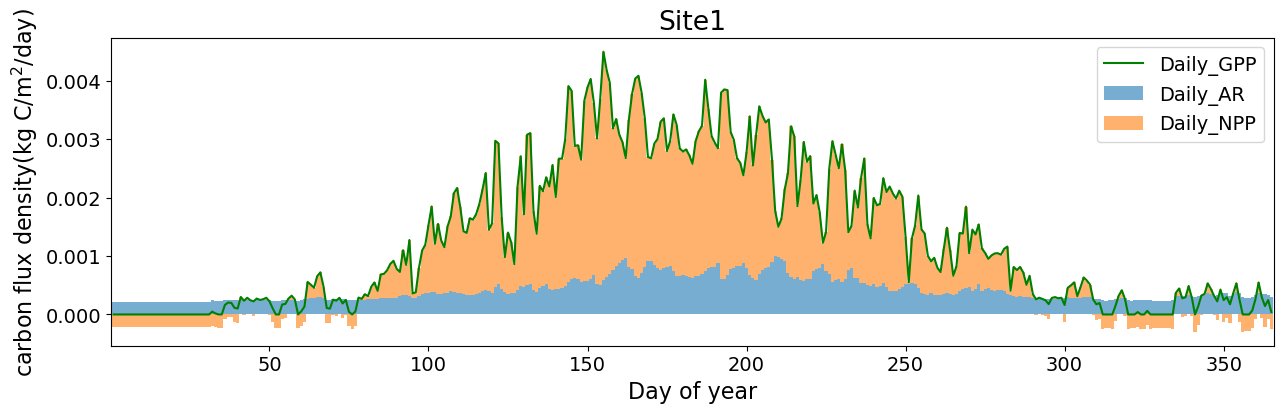

In [19]:
draw_daily_plot(result1_new,'Site1')

<Figure size 640x480 with 0 Axes>

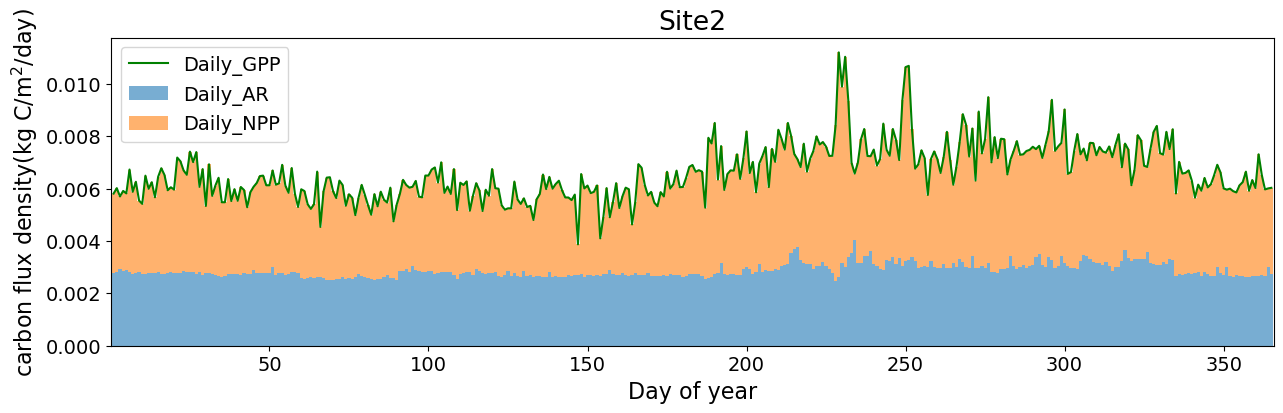

In [20]:
draw_daily_plot(result2_new,'Site2')

<Figure size 640x480 with 0 Axes>

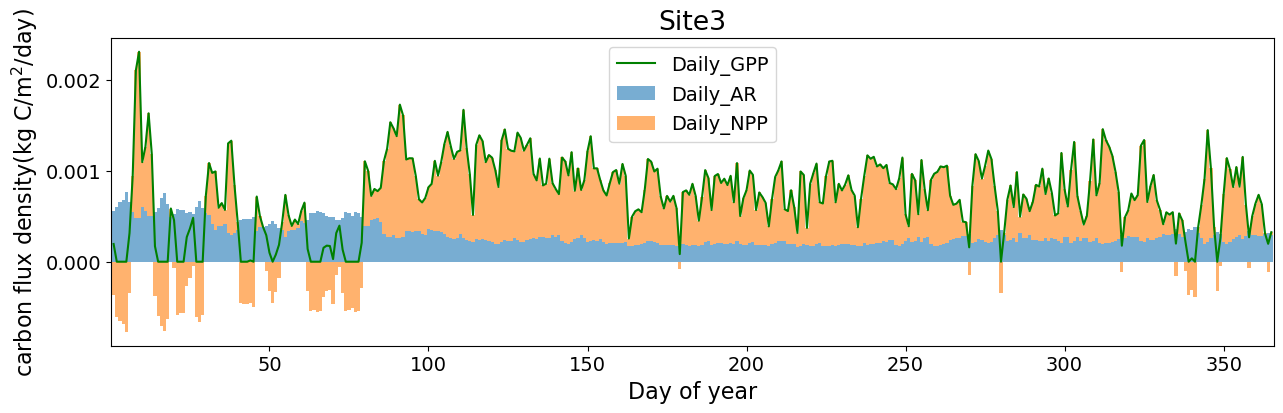

In [21]:
draw_daily_plot(result3_new,'Site3')

In [22]:
def draw_diff(data1, data2):
    iday = np.arange(1,366)
    fig, ax = plt.subplots(figsize=(6, 6))
    # plot lines
    ax.plot(iday, data1['Daily_NPP'], label = "Daily NPP (C6)")
    ax.plot(iday, data2['Daily_NPP'], label = "Daily NPP (C6.1)")
    ax.set_xlabel('Day of year',fontsize=14)
    ax.set_ylabel('carbon flux density(kg C/m$^2$/day)',fontsize=14)
    ax.set_title('C6 vs C6.1 (NPP)',fontsize=20)
    ax.legend()
    plt.show()

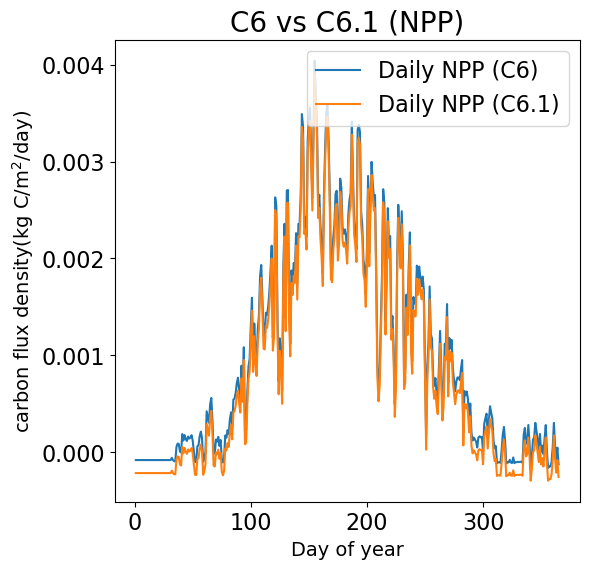

In [23]:
draw_diff(result1,result1_new)

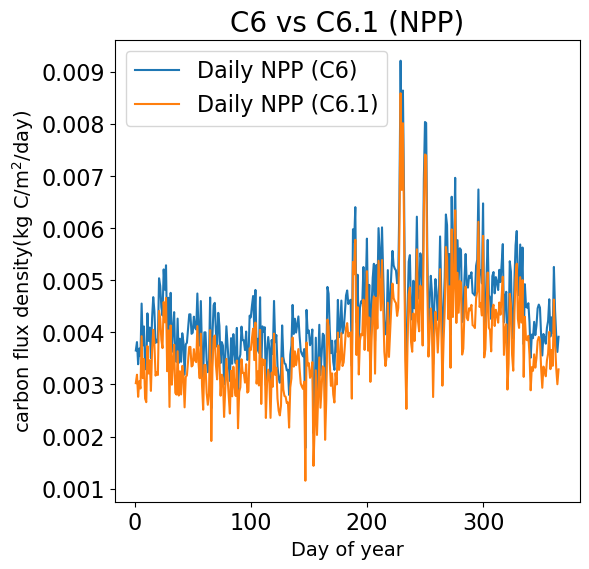

In [24]:
draw_diff(result2,result2_new)

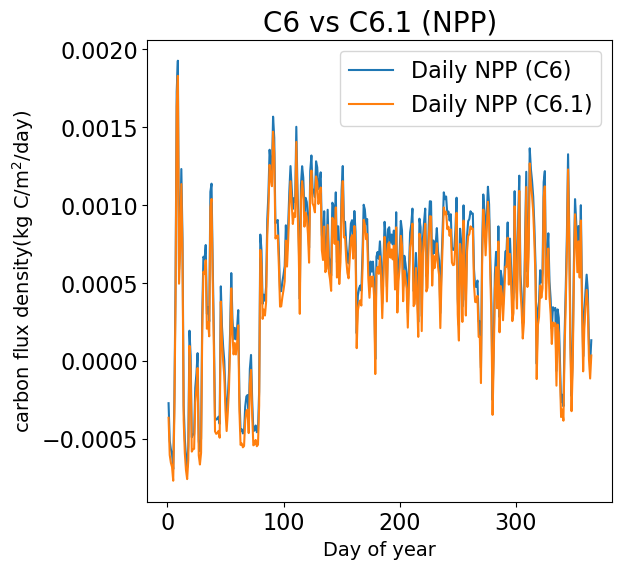

In [25]:
draw_diff(result3,result3_new)

In [59]:
result1['Annual_GR']-result1['Annual_NPP']

-0.33494740530290645

In [62]:
result2['Annual_GR']-result2['Annual_NPP']

-1.4852508449708859

In [63]:
result3['Annual_GR']-result3['Annual_NPP']

-0.19560684345062837